In [ ]:
from google.colab import files
uploaded = files.upload()

Saving credit_card_default.csv to credit_card_default.csv


In [ ]:
# Importing necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

## Preparing credit card data set using pandas

In [ ]:
ccd_preview = pd.read_csv('credit_card_default.csv', index_col='ID')
ccd_preview.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
ccd = pd.read_csv('credit_card_default.csv', index_col='ID')
ccd.rename(columns=lambda x: x.lower(), inplace=True)
ccd.rename(columns={'default payment next month': 'default'}, inplace=True)

In [ ]:
ccd.head(5)

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
#Getting the groups of features
bill_amt_features = ['bill_amt' + str(i) for i in range(1,7)]
pay_amt_features = ['pay_amt' + str(i) for i in range(1,7)]
numerical_features = ['limit_bal', 'age'] + bill_amt_features + pay_amt_features

In [ ]:
#Creating the binary features
ccd['male'] = (ccd['sex'] == 1).astype('int')
ccd['grad_school'] = (ccd['education'] == 1).astype('int')
ccd['university'] = (ccd['education'] == 2).astype('int')
ccd['married'] = (ccd['education'] == 1).astype('int')

In [ ]:
#simplifying pay features
pay_features = ['pay_' + str(i) for i in range(1,7)]
for x in pay_features:
  ccd.loc[ccd[x] <=0, x] = 0

In [ ]:
# simplifying delayed features
delayed_features = ['delayed_' + str(i) for i in range(1,7)]
for pay, delayed in zip(pay_features, delayed_features):
  ccd[delayed] = (ccd[pay] > 0).astype(int)
  # creating new features months delayed
ccd['months_delayed'] = ccd[delayed_features].sum(axis=1)

## Data set is prepared, can be exported as CSV file at this point


### Train Test Val split
This data set can be split into train, test, and validation splits by applying sklearn's train test split twice.

I apply cross validation later in this notebook.

In [ ]:
# Put features into X and Y variables
numerical_features = numerical_features + ['months_delayed']
binary_features = ['male', 'married', 'grad_school', 'university']
X = ccd[numerical_features + binary_features]
y = ccd['default'].astype(int)

In [ ]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/5, random_state=1)

#Setting aside a set of training data without splitting validation for later cross validation
X_2 = X_train.copy()
y_2 = y_train.copy()

#Train and validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 1/4, random_state=1)

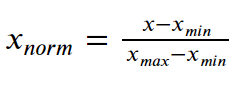

I will use this formula to normalize the non-binary features

In [ ]:
# defining a function to normalize the data
def NormalizeData(mydata):
  return (mydata - np.min(mydata)) / (np.max(mydata) - np.min(mydata))

In [ ]:
class DataNormalization():
  def __init__(self, feature_name):
    self.feature_name = feature_name
    #print('\n>>>>>>>init() called.\n')
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    X_ = X.copy()
    X_[self.feature_name] = (X_[self.feature_name] - np.min(X[self.feature_name])) / (np.max(X_[self.feature_name] - np.min(X_[self.feature_name])))
    return X_


In [ ]:
from sklearn.pipeline import Pipeline

my_pipeline = Pipeline(steps=[
    ('normalizer', DataNormalization(numerical_features))
])

### Define a Model and a test it

In [ ]:
# Define a metric function
from sklearn.metrics import accuracy_score

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

KNN_model = KNeighborsClassifier(n_neighbors=3)

normalized_pipeline = Pipeline([
    ('preprocessor', DataNormalization(numerical_features)),
    ('model', KNN_model)
    ])
pipeline_no_normalization = Pipeline([
    ('model', KNN_model)
])
# Normalize data and fit model
normalized_pipeline.fit(X_train, y_train)
pipeline_no_normalization.fit(X_train, y_train)
#preprocessing of validation data, get predictions
normalized_preds = normalized_pipeline.predict(X_val)
no_normalization_preds = pipeline_no_normalization.predict(X_val)
#Evaluate model
score_1 = accuracy_score(y_val, no_normalization_preds)
score_2 = accuracy_score(y_val, normalized_preds)


print("Accuracy with No Data Normalization, 3 Neighbors:", score_1)
print("Accuracy with Data Normalization, 3 Neighbors:", score_2)

Accuracy with No Data Normalization, 3 Neighbors: 0.7362666666666666
Accuracy with Data Normalization, 3 Neighbors: 0.7776


In [ ]:
y_val

ID
10748    0
12574    1
29677    0
8857     1
21099    0
        ..
29318    0
18630    0
15330    0
14588    0
15012    0
Name: default, Length: 7500, dtype: int64

Normalization definitely helps improve accuracy. I will create a function to obtain a list of metrics quickly: Accuracy, Precision, and Recall

In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
def score_model(X_train, X_val, y_train, y_val, model):
  model.fit(X_train, y_train)
  preds = model.predict(X_val)
  Accuracy_score = accuracy_score(y_val, preds)
  Precision_score = precision_score(y_val, preds)
  Recall_score = recall_score(y_val, preds)
  return {"Accuracy Score:": Accuracy_score, "Precision Score:": Precision_score, "Recall Score:": Recall_score}

In [ ]:
# Now we can be very efficient with scoring models. Here I score both models.
models_to_test = [pipeline_no_normalization, normalized_pipeline]
for model in models_to_test:
  print(score_model(X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val, model=model))

{'Accuracy Score:': 0.7362666666666666, 'Precision Score:': 0.35377358490566035, 'Recall Score:': 0.22482014388489208}
{'Accuracy Score:': 0.7609333333333334, 'Precision Score:': 0.4460742018981881, 'Recall Score:': 0.30995203836930457}


We can see the model accuracy, precison, and recall all improves with data normalization. Notably, precision improves the most. Next, lets create functions to test different numbers of neighors.

In [ ]:
# In lecture, square root of number of observations was a suggested number for K
import math
number_observations = len(X_train)
print("Number of training rows:", number_observations)
sqrt_obs = math.sqrt(number_observations)
print("Square root of number of observations:", sqrt_obs)

Number of training rows: 22500
Square root of number of observations: 150.0


In [ ]:
# numpy's arange can be used to provide a list of numbers
np.arange(3, 151, 7)


array([  3,  10,  17,  24,  31,  38,  45,  52,  59,  66,  73,  80,  87,
        94, 101, 108, 115, 122, 129, 136, 143, 150])

In [ ]:
# K | Val Accuracy
list_of_neigbors_to_test = [x for x in np.arange(3, 151, 7)]
print((list_of_neigbors_to_test))

[3, 10, 17, 24, 31, 38, 45, 52, 59, 66, 73, 80, 87, 94, 101, 108, 115, 122, 129, 136, 143, 150]


In [ ]:
for n_neighbors in list_of_neigbors_to_test:
  KNN_model = KNeighborsClassifier(n_neighbors=n_neighbors)
  normalized_pipeline = Pipeline([
    ('preprocessor', DataNormalization(numerical_features)),
    ('model', KNN_model)
    ])
  print("Testing ",n_neighbors,"neighbors KNN Model with Normalization...")
  (print(score_model(X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val, model=normalized_pipeline)))

Testing  3 neighbors KNN Model with Normalization...
{'Accuracy Score:': 0.7609333333333334, 'Precision Score:': 0.4460742018981881, 'Recall Score:': 0.30995203836930457}
Testing  10 neighbors KNN Model with Normalization...
{'Accuracy Score:': 0.7937333333333333, 'Precision Score:': 0.5898959881129272, 'Recall Score:': 0.23800959232613908}
Testing  17 neighbors KNN Model with Normalization...
{'Accuracy Score:': 0.7973333333333333, 'Precision Score:': 0.5902439024390244, 'Recall Score:': 0.290167865707434}
Testing  24 neighbors KNN Model with Normalization...
{'Accuracy Score:': 0.7976, 'Precision Score:': 0.6033057851239669, 'Recall Score:': 0.26258992805755393}
Testing  31 neighbors KNN Model with Normalization...
{'Accuracy Score:': 0.7985333333333333, 'Precision Score:': 0.5997458703939009, 'Recall Score:': 0.2829736211031175}
Testing  38 neighbors KNN Model with Normalization...
{'Accuracy Score:': 0.8026666666666666, 'Precision Score:': 0.6298342541436464, 'Recall Score:': 0.273

There's a lot going on in the output cell, it may be better strategy to store these metrics in a dictionary, then create a data visualization function to plot these metrics.

In [ ]:
def score_model(X_train, X_val, y_train, y_val, model):
  model.fit(X_train, y_train)
  preds = model.predict(X_val)
  Accuracy_score = accuracy_score(y_val, preds)
  Precision_score = precision_score(y_val, preds)
  Recall_score = recall_score(y_val, preds)
  return {"Accuracy Score:": Accuracy_score, "Precision Score:": Precision_score, "Recall Score:": Recall_score}


In [ ]:
from sklearn import metrics
def get_metrics_dictionary(list_of_neigbors_to_test):
  metrics_dictionary = {}
  for n_neighbors in list_of_neigbors_to_test:
    KNN_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    normalized_pipeline = Pipeline([
    ('preprocessor', DataNormalization(numerical_features)),
    ('model', KNN_model)
    ])
    normalized_pipeline.fit(X_train, y_train)
    preds = normalized_pipeline.predict(X_val)
    Accuracy_score = accuracy_score(y_val, preds)
    Precision_score = precision_score(y_val, preds)
    Recall_score = recall_score(y_val, preds)
    metrics_dictionary[n_neighbors] = [Accuracy_score, Precision_score, Recall_score]
  return metrics_dictionary


In [ ]:
list_of_neigbors_to_test = [x for x in np.arange(3, 151, 7)]
metrics_for_different_neighbors = get_metrics_dictionary(list_of_neigbors_to_test)
print(metrics_for_different_neighbors)

{3: [0.7609333333333334, 0.4460742018981881, 0.30995203836930457], 10: [0.7937333333333333, 0.5898959881129272, 0.23800959232613908], 17: [0.7973333333333333, 0.5902439024390244, 0.290167865707434], 24: [0.7976, 0.6033057851239669, 0.26258992805755393], 31: [0.7985333333333333, 0.5997458703939009, 0.2829736211031175], 38: [0.8026666666666666, 0.6298342541436464, 0.2733812949640288], 45: [0.8021333333333334, 0.6191709844559585, 0.2865707434052758], 52: [0.8037333333333333, 0.6357340720221607, 0.2751798561151079], 59: [0.8033333333333333, 0.6288384512683578, 0.2823741007194245], 66: [0.802, 0.6262068965517241, 0.27218225419664266], 73: [0.8016, 0.6229508196721312, 0.2733812949640288], 80: [0.8014666666666667, 0.6280400572246065, 0.263189448441247], 87: [0.8013333333333333, 0.6232686980609419, 0.2697841726618705], 94: [0.8014666666666667, 0.6265912305516266, 0.2655875299760192], 101: [0.8017333333333333, 0.624484181568088, 0.27218225419664266], 108: [0.8008, 0.6253602305475504, 0.26019184

In [ ]:
accuracy_list = [elem[0] for elem in metrics_for_different_neighbors.values()]
precision_list = [elem[1] for elem in metrics_for_different_neighbors.values()]
recall_list = [elem[2] for elem in metrics_for_different_neighbors.values()]

### Figure 1: Plotting Accuracy vs. K neighbors




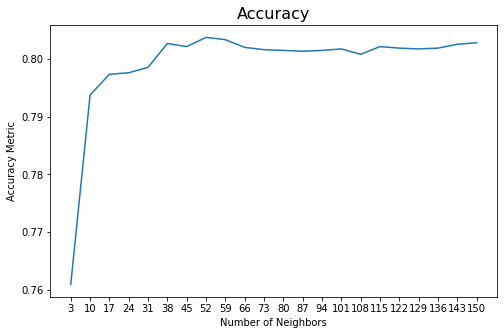

In [ ]:
from matplotlib import pyplot as plt
y = accuracy_list
x = list_of_neigbors_to_test
# naming the x axis
fig, ax = plt.subplots()
ax.set_xticks(list_of_neigbors_to_test)
ax.set_title('Accuracy', fontsize=16)
plt.xlabel('Number of Neighbors')
# naming the y axis
plt.ylabel('Accuracy Metric')

fig.set_size_inches(8, 5)
plt.plot(x,y)
plt.show()

### Figure 2: Plotting Precision vs. K neighbors




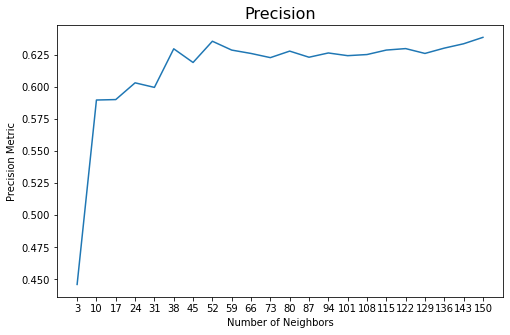

In [ ]:
y = precision_list
x = list_of_neigbors_to_test
# naming the x axis
fig, ax = plt.subplots()
ax.set_xticks(list_of_neigbors_to_test)
ax.set_title('Precision', fontsize=16)

plt.xlabel('Number of Neighbors')
# naming the y axis
plt.ylabel('Precision Metric')

fig.set_size_inches(8,5)
plt.plot(x,y)
plt.show()

### Figure 3: Plotting Recall vs. K neighbors

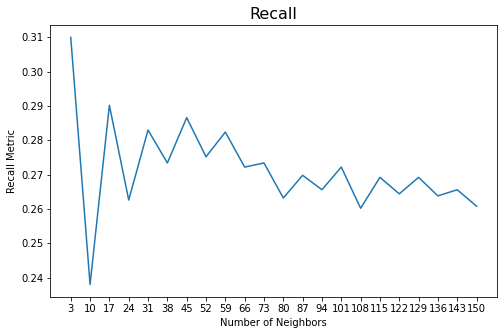

In [ ]:
y = recall_list
x = list_of_neigbors_to_test
# naming the x axis
fig, ax = plt.subplots()
ax.set_xticks(list_of_neigbors_to_test)
ax.set_title('Recall', fontsize=16)
plt.xlabel('Number of Neighbors')
# naming the y axis
plt.ylabel('Recall Metric')
fig.set_size_inches(8,5)

plt.plot(x,y)
plt.show()

In [ ]:
print("Accuracy, Precision and Recall for 52 neighbors:",metrics_for_different_neighbors[52])

Accuracy, Precision and Recall for 52 neighbors: [0.8037333333333333, 0.6357340720221607, 0.2751798561151079]


After examining each plot, it appears 52 neighbors is a good value for higher accuracy 80.3%, higher precision 63.5%, and lower recall 25%. What High Precision and Low Recall (>.5) means for the model is it will return fewer True (Creditor Defaults) results, but it will be more likely to be accurate.

Another way to put this:  

*   the normalized, 52 neighbors KNN model will predict whether someone defaults correctly True or False 80.3% of the time (Accuracy)
*    when the Model identifies someone as defaulting it is correct 63.5% of the time (Precision = Predicts Default Correctly/(True Default + Incorrectly Predicted Default)
*    and IF there is default (True case), it will capture it 25% of the time (Recall = Predicts Default Correctly/(True Default + Missed Defualt)).

I could also parameter tune Leaf Size and Euclidean Distance (p), but I will stop tuning here to pursue K-Fold Cross Validation.

### Figure 4: ROC Curve


In [ ]:
from sklearn.metrics import roc_curve
KNN_model = KNeighborsClassifier(n_neighbors=52)
normalized_pipeline = Pipeline([
  ('preprocessor', DataNormalization(numerical_features)),
  ('model', KNN_model)
  ])

normalized_pipeline.fit(X_train, y_train)

threshold = 0.5
y_pred_prob = normalized_pipeline.predict_proba(X_val)[:,1]
y_pred = (y_pred_prob > threshold).astype(int)
fpr, tpr, ths = roc_curve(y_val, y_pred_prob)

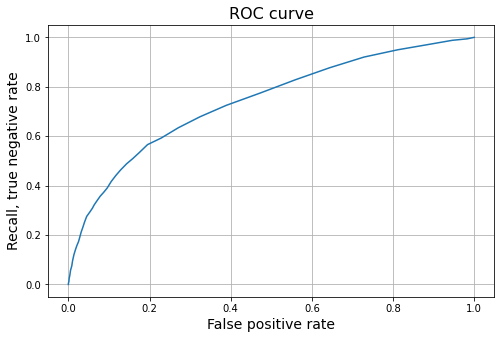

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(fpr,tpr)
ax.set_title('ROC curve', fontsize=16)
ax.set_xlabel('False positive rate', fontsize=14)
ax.set_ylabel('Recall, true negative rate', fontsize=14)
ax.grid();

### K-fold Cross Validation
What if the validation data set I picked is not the most representative? K-Fold cross validation can give me metrics that are more representative of the model. I will use 52 neighbors and data normalization and 10 cross folds and obtain metrics for them.

In [ ]:
KNN_model = KNeighborsClassifier(n_neighbors=52)
normalized_pipeline = Pipeline([
  ('preprocessor', DataNormalization(numerical_features)),
  ('model', KNN_model)
  ])

In [ ]:
from sklearn.model_selection import cross_val_score
#X_2 is X_train without val split, same for y_@
cv10_accuracy_scores = cross_val_score(normalized_pipeline, X_2, y_2,
                         cv=10,
                         scoring='accuracy')
cv10_precision_scores = cross_val_score(normalized_pipeline, X_2, y_2,
                         cv=10,
                         scoring='precision')
cv10_recall_scores = cross_val_score(normalized_pipeline, X_2, y_2,
                         cv=10,
                         scoring='recall')
print("Accuracy Scores:\n", cv10_accuracy_scores)
print("Precision Scores:\n", cv10_precision_scores)
print("Recall Scores:\n", cv10_recall_scores)

Accuracy Scores:
 [0.80416667 0.80666667 0.805      0.79333333 0.79791667 0.80333333
 0.79625    0.80458333 0.80416667 0.81291667]
Precision Scores:
 [0.63043478 0.63414634 0.63135593 0.58018868 0.61780105 0.62946429
 0.59276018 0.62151394 0.63636364 0.67391304]
Recall Scores:
 [0.27358491 0.29433962 0.28113208 0.23207547 0.22264151 0.26603774
 0.24716981 0.29433962 0.26415094 0.29300567]


In [ ]:
import statistics
print("Average Accuracy with 10 crossfolds:\n", statistics.mean(cv10_accuracy_scores))
print("Average Precision with 10 crossfolds:\n", statistics.mean(cv10_precision_scores))
print("Average Recall with 10 crossfolds:\n", statistics.mean(cv10_recall_scores))

Average Accuracy with 10 crossfolds:
 0.8028333333333333
Average Precision with 10 crossfolds:
 0.6247941873415968
Average Recall with 10 crossfolds:
 0.2668477369190712


### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
def CM(y_true, y_pred):
  M = confusion_matrix(y_true, y_pred)
  out = pd.DataFrame(M, index=["Obs Paid", "Obs Default"], columns=["Pred Paid", "Pred default"])
  return out

In [ ]:
threshold = 0.5
normalized_pipeline.fit(X_train, y_train)
y_pred_prob = normalized_pipeline.predict_proba(X_val)[:,1]
y_pred = (y_pred_prob > threshold).astype(int)

In [ ]:
CM(y_val, y_pred)

,Pred Paid,Pred default
Obs Paid,5569,263
Obs Default,1209,459


Finally, analyzing using Test data

In [ ]:
#using full data training data, X_train + X_val
score_model(X_train=X_2, X_val=X_test, y_train=y_2, y_val=y_test, model=normalized_pipeline)

{'Accuracy Score:': 0.8038333333333333,
 'Precision Score:': 0.6438848920863309,
 'Recall Score:': 0.2677636499626028}

In [ ]:
threshold = 0.5
normalized_pipeline.fit(X_2, y_2)
y_pred_prob = normalized_pipeline.predict_proba(X_test)[:,1]
y_pred = (y_pred_prob > threshold).astype(int)
CM(y_test, y_pred)

,Pred Paid,Pred default
Obs Paid,4465,198
Obs Default,979,358


### Figure 5: Plotting ROC Curve with final KNN model, 52 neighbors, data normalization

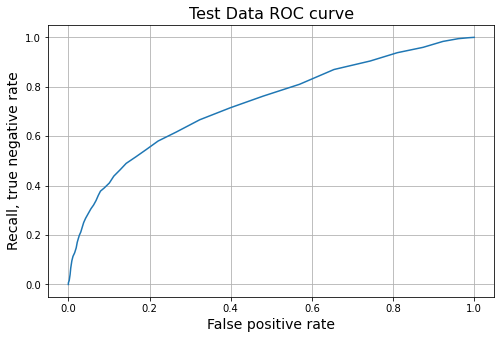

In [ ]:
fpr, tpr, ths = roc_curve(y_test, y_pred_prob)
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(fpr,tpr)
ax.set_title('Test Data ROC curve', fontsize=16)
ax.set_xlabel('False positive rate', fontsize=14)
ax.set_ylabel('Recall, true negative rate', fontsize=14)
ax.grid();

### Figure 6: Plotting Distribution of Predicted Probabilities

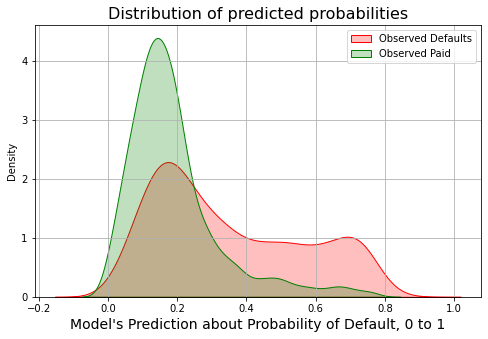

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.kdeplot(y_pred_prob[y_test==1], shade=True, color='red',
            label="Observed Defaults", ax=ax)
sns.kdeplot(y_pred_prob[y_test==0], shade=True, color='green',
            label="Observed Paid", ax=ax)
ax.set_title("Distribution of predicted probabilities", fontsize=16)
ax.set_xlabel('Model\'s Prediction about Probability of Default, 0 to 1', fontsize=14)
ax.legend()
plt.grid();

When the model predicts a low probability, there's a good chance the observation is paid and not default, but when the model predicts a high probability, there is a very good chance the customer is going to default. Ideally, we'd want to see these curves separated completely.